In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dsp import *

我们希望使用 SVM 实现语音识别，步骤如下：

1. 特征提取

2. 模型训练

3. 模型识别

In [13]:
def readDat(filepath):
    # 使用16位有符号整数(int16)格式读取原始数据
    y = np.fromfile(filepath, dtype=np.int16)
    # 将整数值归一化到[-1, 1]范围
    y = y.astype(np.float32) / 32768.0
    return y

In [14]:
# 特征提取
def extractFeature(audio_file, sr=8000, win=256, step=160):
    y = readDat(audio_file)
    
    segments = vad(y, sr, win, step)

    if len(segments) == 0:
        print(f"警告: {audio_file} 没有检测到语音段")
        return None
    
    # 取所有音频段的起始和结束时间
    start = segments[0][0]
    end = segments[-1][1]
    y_speech = y[int(start):int(end)]
    
    # 确保语音段足够长
    min_length = win * 2  # 确保能生成至少一个完整的STFT帧
    if len(y_speech) < min_length:
        print(f"警告: {audio_file} 语音段太短({len(y_speech)}采样点)，填充至{min_length}采样点")
        y_speech = np.pad(y_speech, (0, min_length - len(y_speech)), 'constant')
        # return None


    # 提取MFCC特征
    mfcc_feature = computeMFCC(y_speech, sr, win, D=13, M=26)

    mfcc_mean = np.mean(mfcc_feature, axis=1)
    mfcc_std = np.std(mfcc_feature, axis=1)
    mfcc_max = np.max(mfcc_feature, axis=1)
    mfcc_min = np.min(mfcc_feature, axis=1)


    feature = np.concatenate([mfcc_mean, mfcc_std, mfcc_max, mfcc_min])

    return feature

In [15]:
feature = extractFeature("../myData/00/22307110206-00-03.dat")
print(feature.shape)

(52,)


In [16]:
# 准备数据集
def prepareData(base_dir, classes):
    features = []
    labels = []

    print(f"开始从 {base_dir} 加载数据...")
    
    total_files = 0         # 总文件数
    error_files = 0         # 出错的文件数
    
    # 先计算总文件数
    for idx, name in enumerate(classes):
        class_dir = os.path.join(base_dir, str(idx).zfill(2))
        if os.path.exists(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith('.dat'):
                    total_files += 1
    print(f"找到 {total_files} 个文件")
    
    with tqdm(total=total_files, desc="总进度") as pbar:
        for idx, name in enumerate(classes):
            class_dir = os.path.join(base_dir, str(idx).zfill(2))
            
            if not os.path.exists(class_dir):
                print(f"警告：目录 {class_dir} 不存在，跳过类别 '{name}'")
                continue
                
            class_files = [f for f in os.listdir(class_dir) if f.endswith('.dat')]
            print(f"正在处理类别 '{name}' ({len(class_files)}个文件)...")
            
            for filename in class_files:
                filepath = os.path.join(class_dir, filename)
                feature = extractFeature(filepath)
                if feature is not None:
                    features.append(feature)
                    labels.append(idx)
                else:
                    error_files += 1

                pbar.set_postfix({"出错文件数": error_files})
                pbar.update(1)
            
    print(f"\n处理完成: 共 {total_files} 个文件, 出错 {error_files} 个")
    if len(features) == 0:
        raise ValueError("没有成功处理任何文件!请检查数据路径和文件格式")
    
    return np.array(features), np.array(labels)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib

# 训练SVM模型
def train_svm_model(features, labels, test_size=0.2, random_state=42):
    # 分割训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(
        features, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    # 特征标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(x_train)
    X_test_scaled = scaler.transform(x_test)
    
    # 训练SVM模型
    svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    svm.fit(X_train_scaled, y_train)
    
    # 评估模型
    y_pred = svm.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # 保存模型和标准化器
    joblib.dump(svm, 'svm/svm_model.pkl')
    joblib.dump(scaler, 'svm/scaler.pkl')
    
    return svm, scaler, (X_test_scaled, y_test)

In [18]:
# 使用模型进行识别
def recognize_speech(audio_file, model, scaler, classes):
    # 提取特征
    feature = extractFeature(audio_file)
    if feature is None:
        return "无法检测到语音"
    
    # 标准化特征
    features_scaled = scaler.transform(feature.reshape(1, -1))
    
    # 预测
    probabilities = model.predict_proba(features_scaled)[0]
    class_idx = np.argmax(probabilities)
    confidence = probabilities[class_idx]
    
    return classes[class_idx], confidence

In [19]:
classes = ["数字", "语音", "语言", "处理", "中国", "忠告", "北京", "背景", "上海", "商行",
              "Speech", "Speaker", "Signal", "Sequence", "Processing", "Print", "Project", "File", "Open", "Close"]

# 准备训练数据
features, labels = prepareData('../myData', classes)

开始从 ../myData 加载数据...
找到 2000 个文件


总进度:   0%|          | 0/2000 [00:00<?, ?it/s, 出错文件数=0]

正在处理类别 '数字' (100个文件)...


总进度:   5%|▌         | 100/2000 [00:12<02:14, 14.09it/s, 出错文件数=0]

正在处理类别 '语音' (100个文件)...


总进度:  10%|▉         | 199/2000 [00:24<02:26, 12.31it/s, 出错文件数=0]

正在处理类别 '语言' (100个文件)...


总进度:  15%|█▌        | 303/2000 [00:34<02:17, 12.37it/s, 出错文件数=0]

正在处理类别 '处理' (100个文件)...


总进度:  20%|██        | 402/2000 [00:47<02:29, 10.70it/s, 出错文件数=0]

正在处理类别 '中国' (100个文件)...


总进度:  25%|██▌       | 502/2000 [00:57<00:31, 48.17it/s, 出错文件数=0]

正在处理类别 '忠告' (100个文件)...


总进度:  30%|███       | 601/2000 [01:09<01:52, 12.44it/s, 出错文件数=0]

正在处理类别 '北京' (100个文件)...


总进度:  35%|███▌      | 703/2000 [01:30<03:19,  6.49it/s, 出错文件数=0]

正在处理类别 '背景' (100个文件)...


总进度:  40%|████      | 803/2000 [11:22<01:21, 14.74it/s, 出错文件数=0]   

正在处理类别 '上海' (100个文件)...


总进度:  45%|████▍     | 899/2000 [11:30<02:17,  8.01it/s, 出错文件数=0]

正在处理类别 '商行' (100个文件)...


总进度:  50%|█████     | 1004/2000 [11:35<00:58, 17.11it/s, 出错文件数=0]

正在处理类别 'Speech' (100个文件)...


总进度:  51%|█████▏    | 1026/2000 [11:37<01:07, 14.34it/s, 出错文件数=0]

警告: ../myData/10/22300240004_10_14.dat 语音段太短(480采样点)，填充至512采样点


总进度:  55%|█████▌    | 1104/2000 [11:43<00:47, 18.68it/s, 出错文件数=0]

正在处理类别 'Speaker' (100个文件)...


总进度:  60%|██████    | 1204/2000 [11:50<00:41, 19.03it/s, 出错文件数=0]

正在处理类别 'Signal' (100个文件)...


总进度:  65%|██████▌   | 1303/2000 [11:58<00:39, 17.49it/s, 出错文件数=0]

正在处理类别 'Sequence' (100个文件)...


总进度:  70%|███████   | 1402/2000 [12:06<00:45, 13.20it/s, 出错文件数=0]

正在处理类别 'Processing' (100个文件)...


总进度:  75%|███████▌  | 1500/2000 [12:15<00:27, 18.35it/s, 出错文件数=0]

正在处理类别 'Print' (100个文件)...


总进度:  80%|████████  | 1604/2000 [12:21<00:27, 14.27it/s, 出错文件数=0]

正在处理类别 'Project' (100个文件)...


总进度:  85%|████████▌ | 1705/2000 [12:30<00:15, 19.46it/s, 出错文件数=0]

正在处理类别 'File' (100个文件)...


总进度:  88%|████████▊ | 1763/2000 [12:35<00:23,  9.98it/s, 出错文件数=1]

警告: ../myData/17/23300240026-17-09.dat 没有检测到语音段


总进度:  90%|█████████ | 1800/2000 [12:37<00:09, 20.97it/s, 出错文件数=1]

正在处理类别 'Open' (100个文件)...


总进度:  95%|█████████▌| 1900/2000 [12:45<00:06, 16.16it/s, 出错文件数=1]

正在处理类别 'Close' (100个文件)...


总进度:  95%|█████████▌| 1906/2000 [12:46<00:08, 11.75it/s, 出错文件数=1]

警告: ../myData/19/23300240026-19-07.dat 语音段太短(480采样点)，填充至512采样点


总进度:  98%|█████████▊| 1957/2000 [12:50<00:02, 15.15it/s, 出错文件数=2]

警告: ../myData/19/23300240026-19-13.dat 没有检测到语音段


总进度: 100%|██████████| 2000/2000 [12:53<00:00,  2.58it/s, 出错文件数=2]


处理完成: 共 2000 个文件, 出错 2 个


In [20]:
# 训练模型
svm_model, scaler, test_data = train_svm_model(features, labels)

Accuracy: 0.8650
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.77      1.00      0.87        20
           2       1.00      0.85      0.92        20
           3       0.79      0.95      0.86        20
           4       1.00      0.90      0.95        20
           5       0.94      0.85      0.89        20
           6       0.69      0.90      0.78        20
           7       0.93      0.70      0.80        20
           8       0.95      0.95      0.95        20
           9       0.94      0.85      0.89        20
          10       0.78      0.90      0.84        20
          11       0.65      0.75      0.70        20
          12       0.90      0.90      0.90        20
          13       1.00      0.85      0.92        20
          14       0.89      0.85      0.87        20
          15       0.82      0.90      0.86        20
          16       0.77      0.85      0.

Accuracy: 0.8650
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        20
           1       0.77      1.00      0.87        20
           2       1.00      0.85      0.92        20
           3       0.79      0.95      0.86        20
           4       1.00      0.90      0.95        20
           5       0.94      0.85      0.89        20
           6       0.69      0.90      0.78        20
           7       0.93      0.70      0.80        20
           8       0.95      0.95      0.95        20
           9       0.94      0.85      0.89        20
          10       0.78      0.90      0.84        20
          11       0.65      0.75      0.70        20
          12       0.90      0.90      0.90        20
          13       1.00      0.85      0.92        20
          14       0.89      0.85      0.87        20
          15       0.82      0.90      0.86        20
          16       0.77      0.85      0.

/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 35821 (\N{CJK UNIFIED IDEOGRAPH-8BED}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 35328 (\N{CJK UNIFIED IDEOGRAPH-8A00}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/keats/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: Us

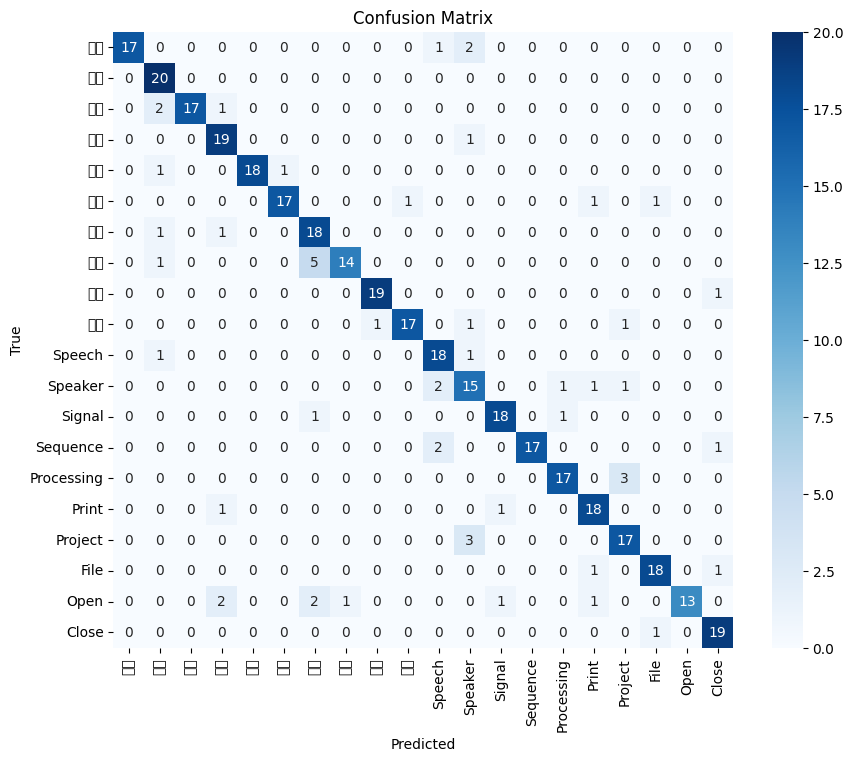

In [21]:
# 绘制混淆矩阵
def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# 拆包
svm_model, scaler, test_data = train_svm_model(features, labels)
X_test_scaled, y_test = test_data

# 预测
y_pred = svm_model.predict(X_test_scaled)
plot_confusion_matrix(y_test, y_pred, classes)

In [22]:
# 测试识别
test_dir = "/mnt/c/Users/Keats/Documents/录音/"

for filename in os.listdir(test_dir):
    if filename.endswith('.dat') or filename.endswith('.wav'):
        test_file = os.path.join(test_dir, filename)
        predicted_class, confidence = recognize_speech(test_file, svm_model, scaler, classes)
        print(f"{filename} -> 识别结果: {predicted_class}，置信度: {confidence:.4f}")

录音.wav -> 识别结果: 语言，置信度: 0.1461
